In [224]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from collections import defaultdict

In [255]:
def plot(df, title, display_legend=False):
    
    image_names = np.unique(df['image'] )
    
    # compute the average cell density
    densities=defaultdict(list)
    
    for image in image_names:
        image_data = df[df['image']==image].to_numpy()[:,[1,2]]
        for depth, value  in zip(image_data[:,0],image_data[:,1]):
            densities[depth].append(value)
            
    average={}
    median={}
    for key, value in densities.items():
        average[key] = np.average(value)
        median[key] = np.median(value)
    
    plt.figure(figsize=(10,10))
    for image in image_names:
        image_data = df[df['image']==image].to_numpy()[:,[0,1,2]]
        plt.plot(image_data[:,2], image_data[:,1])
        
    plt.plot(list(average.values()), list(average.keys()), linewidth=5, c='y', label='average values')
    plt.plot(list(median.values()),list(median.keys()), linewidth=5, c='black', label='median values')
    plt.title(f'{title} Cell density as a function of SSCX region percentage of depth.')
    plt.gca().set_ylabel("SSCX region percentage of depth")
    plt.gca().set_xlabel("Cell density cells/mm3")
    plt.gca().invert_yaxis()
    
    if display_legend:
        lgnd = plt.legend(loc="upper left", scatterpoints=1, fontsize=10)
        for i in range(1):
            lgnd.legendHandles[i]._sizes = [5]
            lgnd.legendHandles[i]._alpha = 1 

In [288]:
df = pd.DataFrame()
densities = []

file_list = glob.glob('/gpfs/bbp.cscs.ch/project/proj53/CellDensitiesProject/Production/2024/Density/01242024/Per_percentage//*.csv')
for file in file_list:
    df_image = pd.read_csv(file, index_col=0)
    densities.append(df_image.densities)
    


In [352]:
densities_mean = np.mean(densities)
std_dev = np.std(densities) * 1
print(densities_mean, std_dev)
df = pd.DataFrame()
frames = []
for file in file_list:
    df_image = pd.read_csv(file, index_col=0)
    if np.mean(df_image.densities) < std_dev:
        print(np.unique(df_image.image))
    else:
        frames.append(df_image)

df = pd.concat(frames)

82613.61433704545 18980.01521230611


/tmp/ipykernel_22474/943012253.py:34: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  lgnd.legendHandles[i]._sizes = [5]
/tmp/ipykernel_22474/943012253.py:35: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  lgnd.legendHandles[i]._alpha = 1


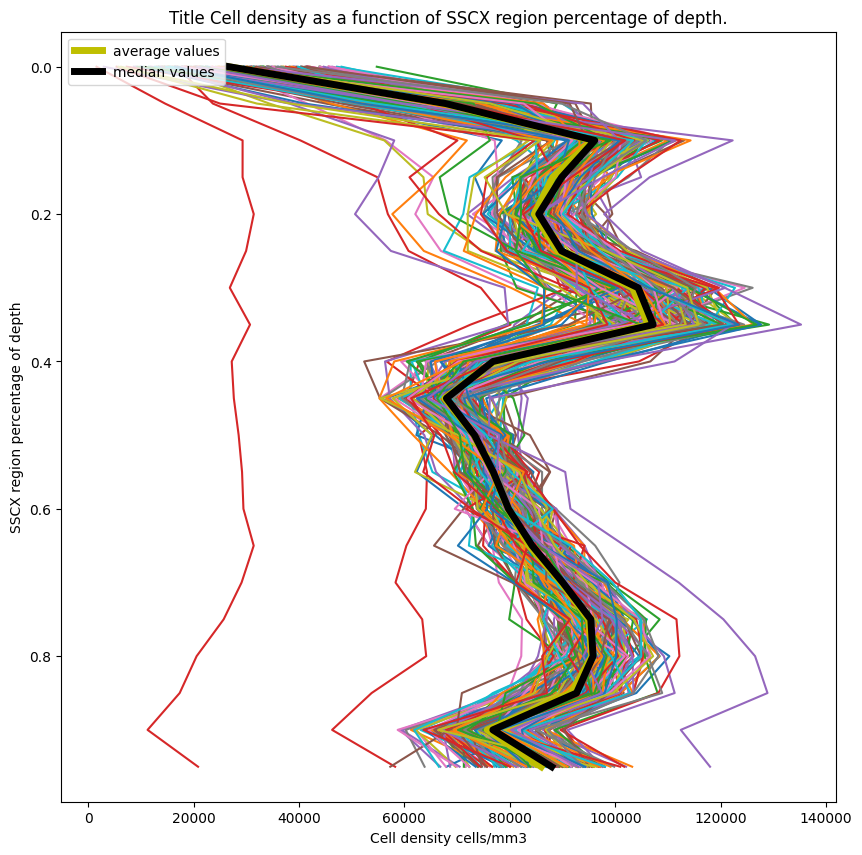

In [353]:
plot(df, 'Title', display_legend=True)

In [422]:

'''
x = np.linspace(0.1, 9.9, 20)
y = 3.0 * x
#some confidence interval
ci = 1.96 * np.std(y)/np.sqrt(len(x))

fig, ax = plt.subplots()
ax.plot(x,y)
ax.fill_between(x, (y-ci), (y+ci), color='b', alpha=.1)
'''

image_names = np.unique(df['image'] )

# compute the average cell density
densities=defaultdict(list)

for image in image_names:
    image_data = df[df['image']==image].to_numpy()[:,[1,2]]
    for depth, value  in zip(image_data[:,0],image_data[:,1]):
        densities[depth].append(value)

average={}
for key, value in densities.items():
    average[key] = np.average(value)
    
y=  np.array(list(average.values()))
x = np.array(list(average.keys()))


In [449]:
percentage = np.unique(df.depth_percentage)
print(percentage.shape)
densities = np.array(list(df.groupby('depth_percentage')['densities'].apply(list).values))
print(densities.shape)

(20,)
(20, 185)


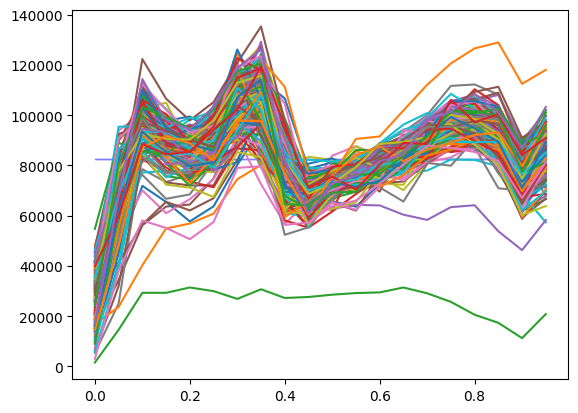

In [460]:
ci = 0.1 * np.std(densities) / np.mean(densities)
_= plt.plot(percentage, densities)


plt.fill_between(percentage, (densities.mean()-ci), (densities.mean()+ci), color='blue', alpha=0.5)

 percentage (20,), densities (20, 185), density_std (20,), density_mean (20,)


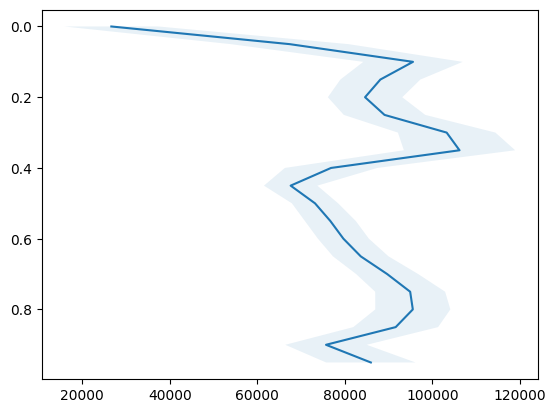

In [517]:
percentage = np.unique(df.depth_percentage)
densities = np.array(list(df.groupby('depth_percentage')['densities'].apply(list).values))

density_std = np.std(densities, axis=1)
density_mean = densities.mean(axis=1)

print(f' percentage {percentage.shape}, densities {densities.shape}, density_std {density_std.shape}, density_mean {density_mean.shape}')

plt.plot (density_mean, percentage)
plt.fill_betweenx(percentage,density_mean-density_std,density_mean+density_std,alpha=.1)
plt.gca().invert_yaxis()

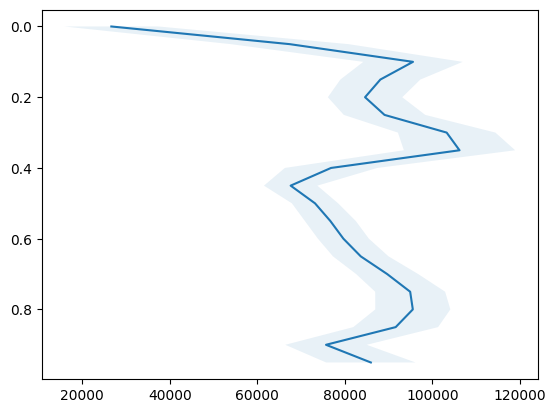

In [ ]:
plt.fill_betweenx